## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

In [2]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

--2025-01-17 18:35:04--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://www.dropbox.com/scl/fi/pkkpoxlm7beasryexpdf8/data_000637.txt?rlkey=rkm2em1v57hewglzelmin21c9 [segue]
--2025-01-17 18:35:06--  https://www.dropbox.com/scl/fi/pkkpoxlm7beasryexpdf8/data_000637.txt?rlkey=rkm2em1v57hewglzelmin21c9
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc203168bf48d4cd9132b708f6e4.dl.dropboxusercontent.com/cd/0/inline/CiXpvMfz-Z5KPo57vfpLQNWqn_letyaMAO2kgD0HIpKnTVTZH1TELceNTvm5uJ8hZrAd5BxCT4kkox9-dT6qCFB23dkf2auh1EfhCCpwrZSBJARW8uPweK1-VtqV5RPP-qI/file# [segue]
--2025-01-17 18:35:07--  https://uc203168bf48d4cd9132b708f6e4.dl.dropboxusercontent.com/cd/0/inline/CiXpvMfz-Z5KP

In [4]:
#!cat data_000637.txt
#to obtain TDCX_MEANS in ns *25/30
#For the rest everything is like a clock: TDC_MEANS -> BX_COUNTER -> ORDBIT_CNT (these are the digits)

#pd.DataFrame("data_00637.txt")

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

1.

In [54]:
#NO

#def read_rows(N,file):
#    df=pd.read_csv(file,nrows=N)
#    return df


df=pd.read_csv("data_000637.txt")
df.sort_values(by="ORBIT_CNT")  #We sort the values. This will be useful later (It didn't work, but I tried)
print(f"Number of rows (Pandas method): {len(df)}") #We see the number of rows in the dataset

N=200000 #We choose 10k<N<nrows

df=pd.read_csv("data_000637.txt",nrows=N)
df.head()

Number of rows (Pandas method): 1310720


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25


2. Find out the number of BX in a ORBIT (the value 'x').

In [42]:
#Each orbit has ORBIT_CNT=nx*BX. We want to find nx
#Solution from senior

df["BX_COUNTER"].max()
df.iat[1,2]

np.int64(124)

In [43]:
#Each orbit has ORBIT_CNT=nx*BX. We want to find nx
#Ask !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


dg=df[df["ORBIT_CNT"]==3869200167] #We choose a specific values, could be any one
#dg1.groupby(["ORBIT_CNT"]).max()
dg1=df.groupby(["ORBIT_CNT"]).count()

In [8]:
#NO (NON GUARDARE)
"""
# Group by "ORBIT_CNT" and find the maximum value of "BX_COUNTER"
max_bx_counter_per_orbit = df.groupby("ORBIT_CNT")["BX_COUNTER"].max()

# Display the result
print(max_bx_counter_per_orbit)
"""

'\n# Group by "ORBIT_CNT" and find the maximum value of "BX_COUNTER"\nmax_bx_counter_per_orbit = df.groupby("ORBIT_CNT")["BX_COUNTER"].max()\n\n# Display the result\nprint(max_bx_counter_per_orbit)\n'

In [45]:
#Ok, apparently this is not a counter
#I just blindly did what Zanetti said
xx=df["BX_COUNTER"].max() #maximum number of counts
dt=xx*25*1e-9 #s
print("Period of the ''clock'': ", dt)

Period of the ''clock'':  8.907500000000001e-05


3. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [10]:
#Reading the whole dataset
df=pd.read_csv("data_000637.txt")
T=len(df["ORBIT_CNT"]) #total measure time
print(f"Total data taking time: {T*dt:.2f}s") #Check this with someone else !!!!!

Total data taking time: 116.75s


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [47]:
#Sort the datasets: it's similar to how we would sort hours, min, s
df_sort = df.sort_values(by=["ORBIT_CNT", "BX_COUNTER","TDC_MEAS"])
df_sort #Check

#Create a list of times
df_sort["time (ns)"]=np.arange(0,len(df.iloc[:,1]))*25*1e9

print(df_sort)

        HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0          1     0          123  3869200167        2374        26   
1          1     0          124  3869200167        2374        27   
2          1     0           63  3869200167        2553        28   
3          1     0           64  3869200167        2558        19   
4          1     0           64  3869200167        2760        25   
...      ...   ...          ...         ...         ...       ...   
199995     1     0          139  3869202157          76         0   
199996     1     0           62  3869202157          76         2   
199997     1     1            2  3869202157          94        15   
199998     1     1            1  3869202157          96        13   
199999     1     1            3  3869202157         107        19   

           time (ns)  
0       0.000000e+00  
1       2.500000e+10  
2       5.000000e+10  
3       7.500000e+10  
4       1.000000e+11  
...              ...  
199995  4.

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [12]:
#We make a copy of the dataset
df1=df.copy()
hd=npr.randint(0,2,len(df))
df1.iloc[:,0]=hd
df1

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,0,0,139,3869211171,769,0


6\. Create a new DataFrame that contains only the rows with HEAD=1.

In [13]:
df2=df.copy()
df2.iloc[:,0]=np.ones(len(df))
df2

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

0    123
1    124
2     63
3     64
4     64
Name: TDC_CHANNEL, dtype: int64


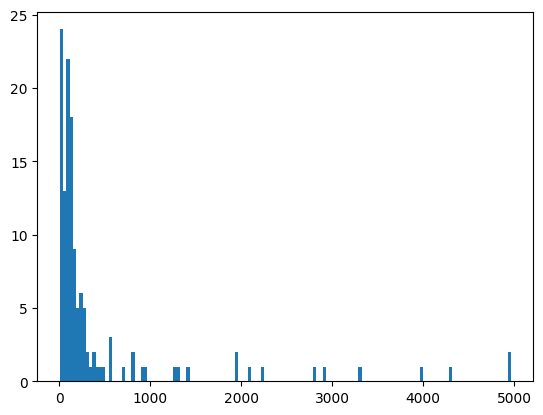

In [90]:
df1=df[df.iloc[:,1]==0]["TDC_CHANNEL"]
df2=df[df.iloc[:,1]==1].groupby("TDC_CHANNEL").count() ["HEAD"]

print(df1.head())
bins =plt.hist(df2,bins=139)

First FPGA [0]: 



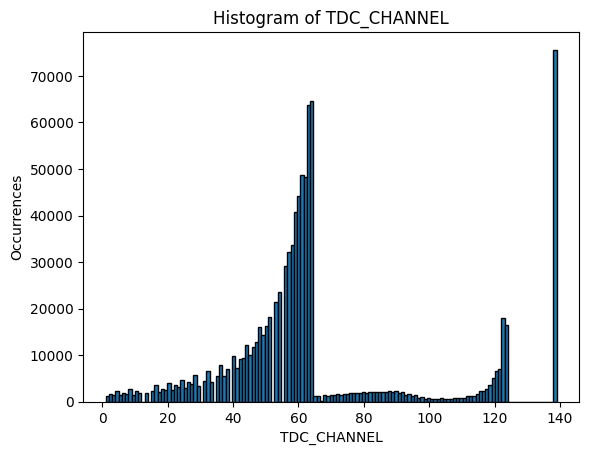

Second FPGA [1]: 



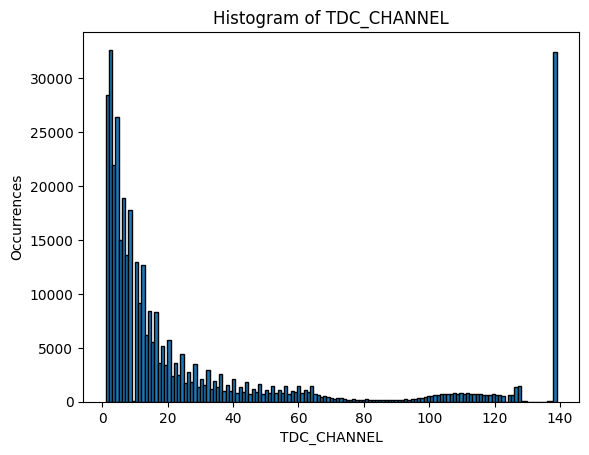

In [21]:
#We split the datasets in two: one for each FPGA
dg0= df[df.iloc[:,1]==0]
dg1= df[df.iloc[:,1]==1]

#Function to plot the histogram
def hist_df(df,field: str,normalize=True):
    dg= df[[field]]
    # Plot the histogram
    plt.hist(dg[field], bins=139, edgecolor='black',density=normalize)  # 'bins'= number of channels
    plt.title(f"Histogram of {field}")
    plt.xlabel(field)
    plt.ylabel("Occurrences")
    plt.show()

print("First FPGA [0]: \n")
hist_df(dg0,"TDC_CHANNEL",normalize=False)
print("Second FPGA [1]: \n")
hist_df(dg1,"TDC_CHANNEL",normalize=False)

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [15]:
#reimport (just to be sure)
df=pd.read_csv("data_000637.txt")
df1 = df.groupby(df.iloc[:, 2]).count() 
df1=df1[[df1.columns[0]]] #The counts are the same for each attribute, so we pick "HEAD"
df1.columns.values[0] = "NCounts" #Rename column
df1=df1.sort_values(by="NCounts",ascending=False) #Sort in descending order
print("Most 3 noisy channels: \n", df1[0:3])

Most 3 noisy channels: 
              NCounts
TDC_CHANNEL         
139           108059
64             66020
63             64642


9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [127]:
#(a) Count the number of unique orbits:
df2 = df.groupby(df.iloc[:, 3]).nunique() 
print("Number of unique orbits: ",len(df2))  #Controlarre !!!!!!!!!!
#(b) Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139
df3=df[df.iloc[:,2]==139]  #Filter by the measurement from TDC_CHANNEL
df3= df3.groupby(df3.iloc[:, 3]).nunique() 
print("Number of unique orbits with at least one measurement from TDC_CHANNEL=139: ",len(df3))

Number of unique orbits:  11001
Number of unique orbits with at least one measurement from TDC_CHANNEL=139:  10976
